
#  FISH CLASSIFICATION 

**Dataset**

This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey for a university-industry collaboration project at Izmir University of Economics, and this work was published in ASYU 2020. The dataset includes gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, shrimp image samples.

## 1. Importing The Modules
   

In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

## 2.Loading The Data 

In [2]:
direc = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Gilt-Head Bream
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet


### 2.1 Displaying First 9 Images  

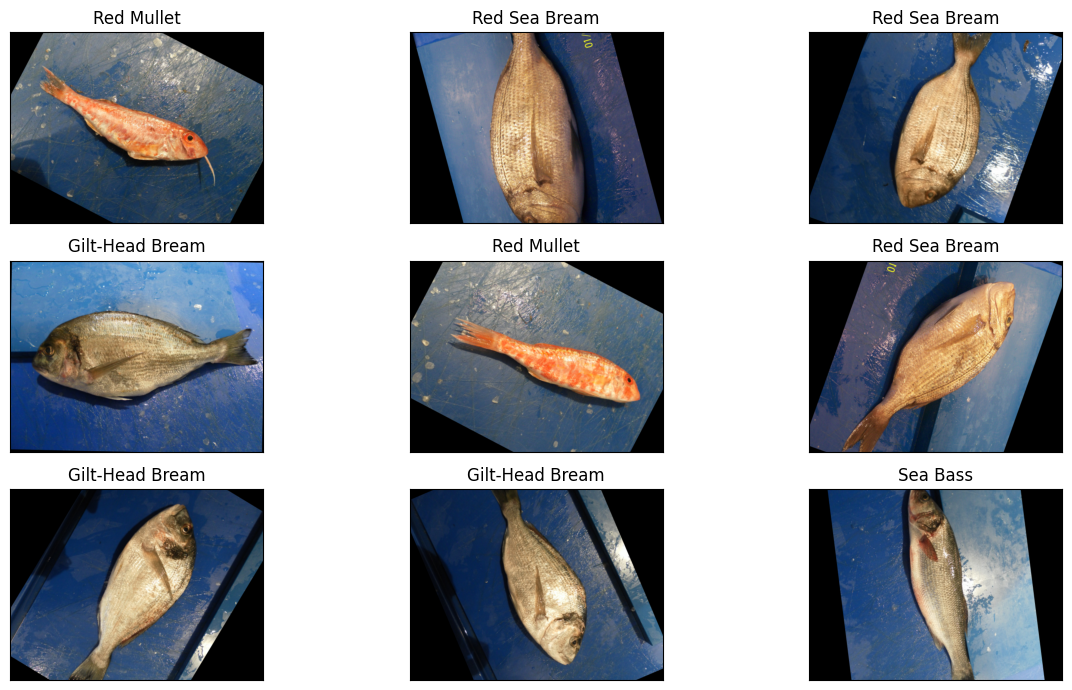

In [3]:
# Showing 9 Images 
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()


### 2.1 Shape Of DataFrame  

In [4]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


### 2.3 Types Of Fishes  

In [5]:
img_df['Labels'].value_counts(ascending=True)

Labels
Red Mullet            1000
Red Sea Bream         1000
Gilt-Head Bream       1000
Sea Bass              1000
Striped Red Mullet    1000
Trout                 1000
Black Sea Sprat       1000
Hourse Mackerel       1000
Shrimp                1000
Name: count, dtype: int64

## 3. Model

### 3.1 Splitting The Data

In [6]:
# Set data split ratios
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15


# Split the data into training, validation, and testing sets
x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

# Print the shapes of the datasets
print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)

Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


### 3.2 Augmenating The Data

In [7]:
# Initialize image data generator
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Set target image size
img_size=(224, 224)    

# Create data generators for training, testing, and validation
x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


### 3.3 Creating The Model

In [8]:
# Define the fully connected model
fc_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Ensure input_shape is correctly specified
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation="softmax")  # Adjust the number of classes as needed
])

# Compile the model with optimizer, loss function, and metrics
fc_model.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 3.4 Training The Model

In [10]:
# Set up EarlyStopping callback to monitor accuracy
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

# Train the model with the training data and validate on the validation set
mo_fit = fc_model.fit(x_train,
                validation_data = x_val,
                epochs = 10, callbacks=Callback)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 108s 500ms/step - accuracy: 0.5210 - loss: 1.3221 - val_accuracy: 0.7178 - val_loss: 0.8710
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 79s 365ms/step - accuracy: 0.6950 - loss: 0.8745 - val_accuracy: 0.7711 - val_loss: 0.6475
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 80s 368ms/step - accuracy: 0.7959 - loss: 0.6041 - val_accuracy: 0.8489 - val_loss: 0.4569
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 78s 361ms/step - accuracy: 0.8463 - loss: 0.4437 - val_accuracy: 0.8844 - val_loss: 0.3604
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 78s 361ms/step - accuracy: 0.8846 - loss: 0.3370 - val_accuracy: 0.8767 - val_loss: 0.3251
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 78s 357ms/step - accuracy: 0.9091 - loss: 0.2631 - val_accuracy: 0.9144 - val_loss: 0.2617
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 79s 361ms/step - accuracy: 0.9228 - loss: 0.2199 - val_accuracy: 0.9267 - val_loss: 0.2526
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 80s 368ms/step - accuracy: 0.9330 - loss: 

### 3.5 Model Summary

In [11]:
print('Model summary :')
print()
fc_model.summary()

Model summary :



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,856,157 (220.70 MB)

 Trainable params: 19,285,385 (73.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,570,772 (147.14 MB)

### 3.6 Model Accuracy and Validation Performance


In [13]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step - accuracy: 0.9161 - loss: 0.2351
Test accuracy is :  92.37037301063538 %


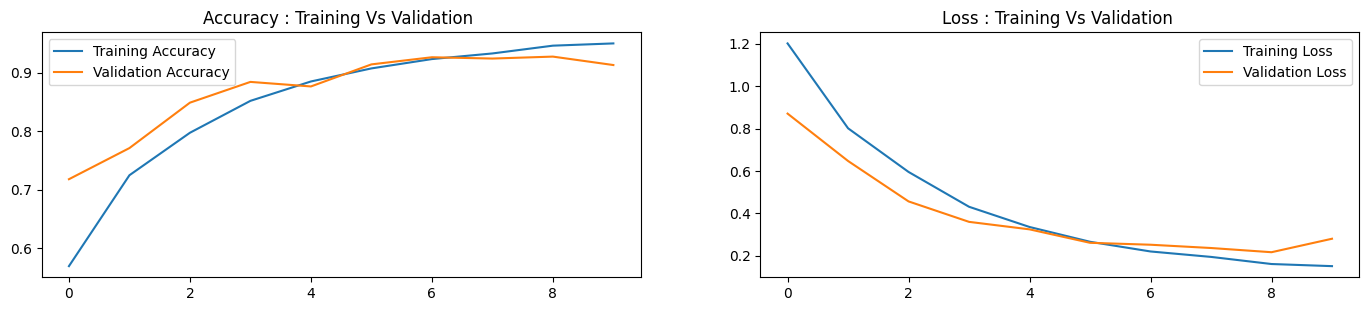

In [14]:
# Retrieve training and validation metrics from the training history
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']

plt.figure(figsize=(17, 7))
# Plot training vs validation accuracy
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')

# Plot training vs validation loss
plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')

plt.show()

### 3.7 Model Testing: Prediction vs Actual

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


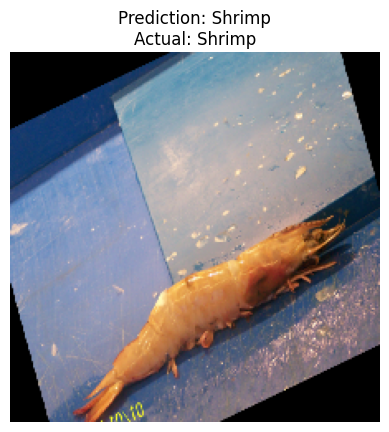

In [15]:
# Load and preprocess the image
img_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00006.png' 
img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0) 
img_array /= 255.0  

# Make predictions using the trained model
predictions = fc_model.predict(img_array)  
predicted_class = np.argmax(predictions, axis=1)[0] 

# Define class names for the predictions
class_names = [
    'Black Sea Sprat',
    'Gilt-Head Bream',
    'Horse Mackerel',
    'Red Mullet',
    'Red Sea Bream',
    'Sea Bass',
    'Shrimp',
    'Striped Red Mullet',
    'Trout'
]
true_class_index = 6  # True class index for the image

# Display the image with prediction and actual class
plt.imshow(img) 
plt.title(f'Prediction: {class_names[predicted_class]}\nActual: {class_names[true_class_index]}')
plt.axis('off') 
plt.show() 
